Store Item Demand Forecasting


In [4]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

In [5]:
df=pd.read_csv('train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
df['sales']=df['sales'].astype('float')

In [7]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0


In [8]:
df['date']=pd.to_datetime(df['date'])
df['MonthDate']=df['date'].dt.to_period('M').dt.to_timestamp()
df_Monthly=df.groupby('MonthDate').agg({'sales':'sum'})



<Axes: xlabel='MonthDate', ylabel='sales'>

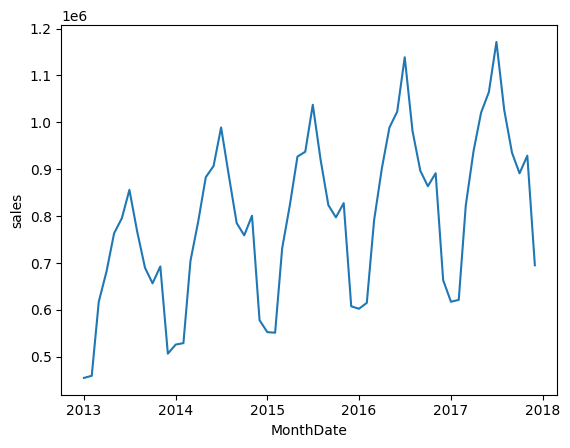

In [9]:
sns.lineplot(data=df_Monthly,x=df_Monthly.index,y=df_Monthly['sales'])

 Augmented Dickey-Fuller (ADF) test :
 is a statistical test for stationarity in a time series. A stationary time series has a constant mean, variance, and autocorrelation structure over time.</br>

The output of the adfuller function is a tuple containing the following elements:

ADF Statistic: This is the test statistic itself.</br>
p-value: The probability of observing a test statistic as extreme as the one calculated,assuming the null hypothesis is true.</br>  
Used Lag: The number of lags used in the ADF regression.</br>
Number of Observations: The number of observations used for the ADF regression and calculation of the critical values.</br>
Critical Values: Critical values for the test statistic at the 1%, 5%, and 10% levels.</br>
IC Best: The maximized information criterion if autolag is not None.</br>


In [10]:
from statsmodels.tsa.stattools import adfuller
adfTest=adfuller(df_Monthly['sales'],autolag='AIC')
adfTest 

(-5.247518850016353,
 7.026495391574688e-06,
 11,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 1114.7870935545418)

In [11]:
testStats=pd.Series(adfTest[0:4], index=['Test Statistic','p-value','# lags used', 'number of observations'])
testStats

Test Statistic            -5.247519
p-value                    0.000007
# lags used               11.000000
number of observations    48.000000
dtype: float64

In [12]:
for key , values in adfTest[4].items():
    print("criticality :",key , values)

criticality : 1% -3.5745892596209488
criticality : 5% -2.9239543084490744
criticality : 10% -2.6000391840277777


critical values > Test Statistic ,so data is stationary

<h3>Now lets use ARIMA model for forcasting and find the parametrs (p,d,q)</h3>

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

p: Number of autoregressive (AR) terms. This is determined by the PACF plot.</br>
d: Number of differences required for stationarity. This is determined by the time series plot and ADF test.</br>
q: Number of moving average (MA) terms. This is determined by the ACF plot.</br></br>
AR,I,MA--->(p,d,q)

If data is already stationary, then the value of d (differencing) will be 0

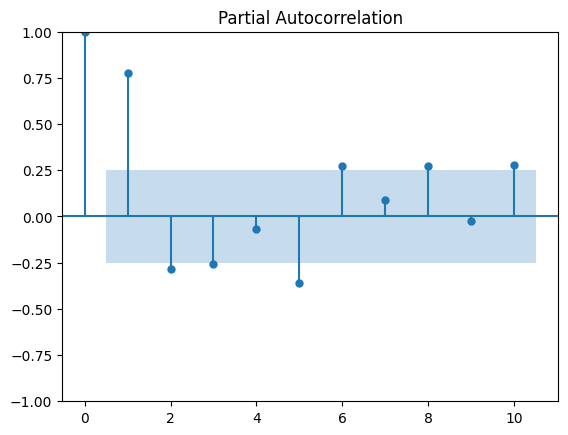

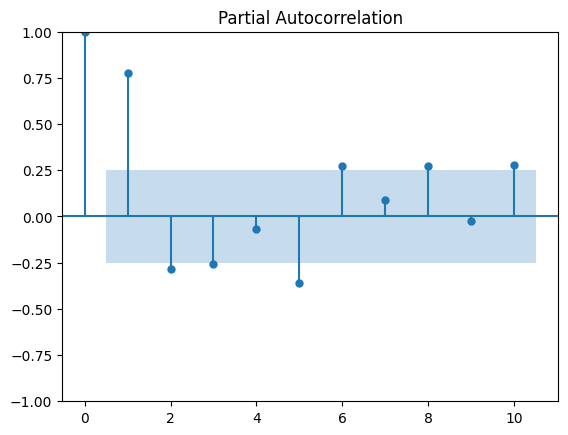

In [14]:
#find q
plot_pacf(df_Monthly['sales'], lags=10)

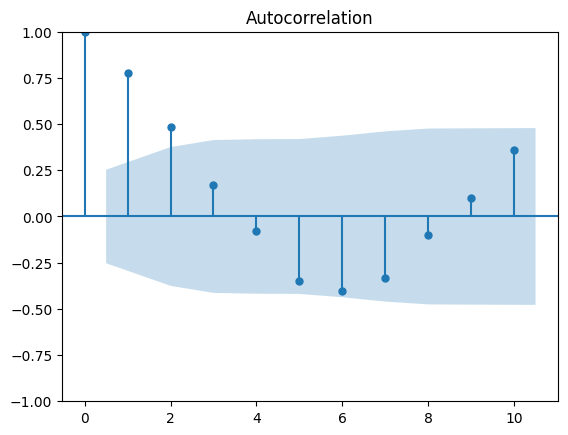

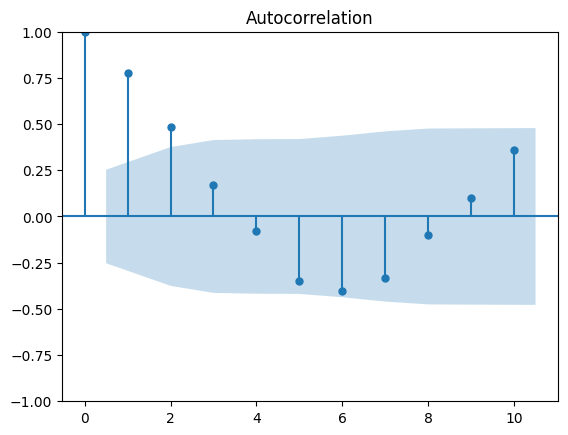

In [15]:
plot_acf(df_Monthly['sales'], lags=10)

<module 'matplotlib' from 'C:\\Users\\samar\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\__init__.py'>

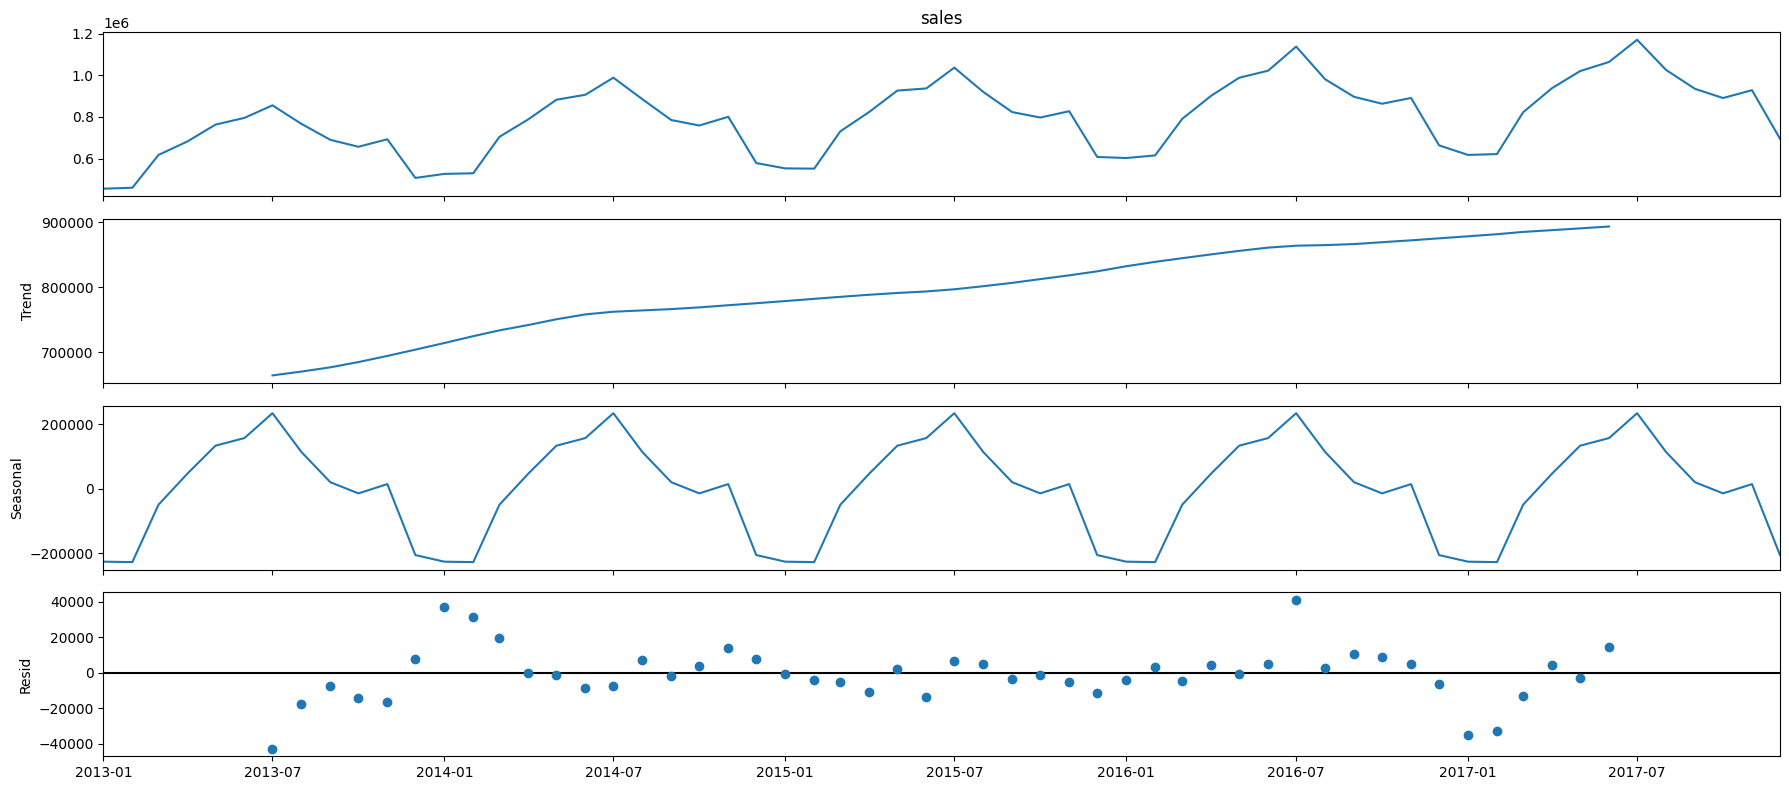

In [16]:
y = df_Monthly["sales"]
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt

In [17]:
train=df_Monthly[:round(len(df_Monthly)*70/100)]
test=df_Monthly[round(len(df_Monthly)*70/100):]

model=ARIMA(train['sales'],order=(2,0,3))
modelAR=model.fit()
pred=modelAR.predict(start=test.index[0],end=test.index[-1])

C:\Users\samar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\samar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\samar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [18]:
df_Monthly['arimaPred']=pred


<Axes: xlabel='MonthDate', ylabel='sales'>

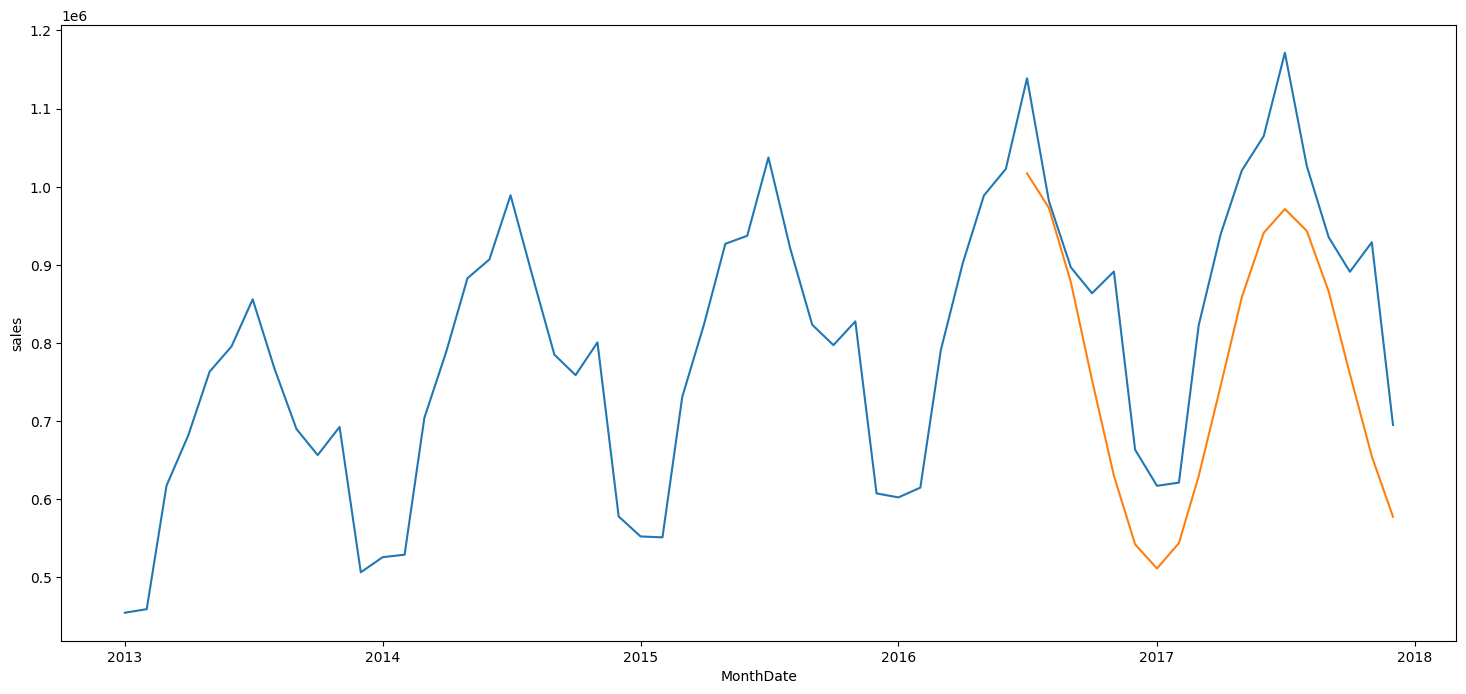

In [19]:
#df_Monthly.dropna()
sns.lineplot(data=df_Monthly , x=df_Monthly.index , y='sales')
sns.lineplot(data=df_Monthly , x=df_Monthly.index , y='arimaPred')

In [20]:
dates=pd.DataFrame(pd.date_range(start='2018-01-01' , end='2018-12-01' , freq='MS'),columns=['Date'])
dates.set_index('Date', inplace=True)


<Axes: xlabel='MonthDate', ylabel='sales'>

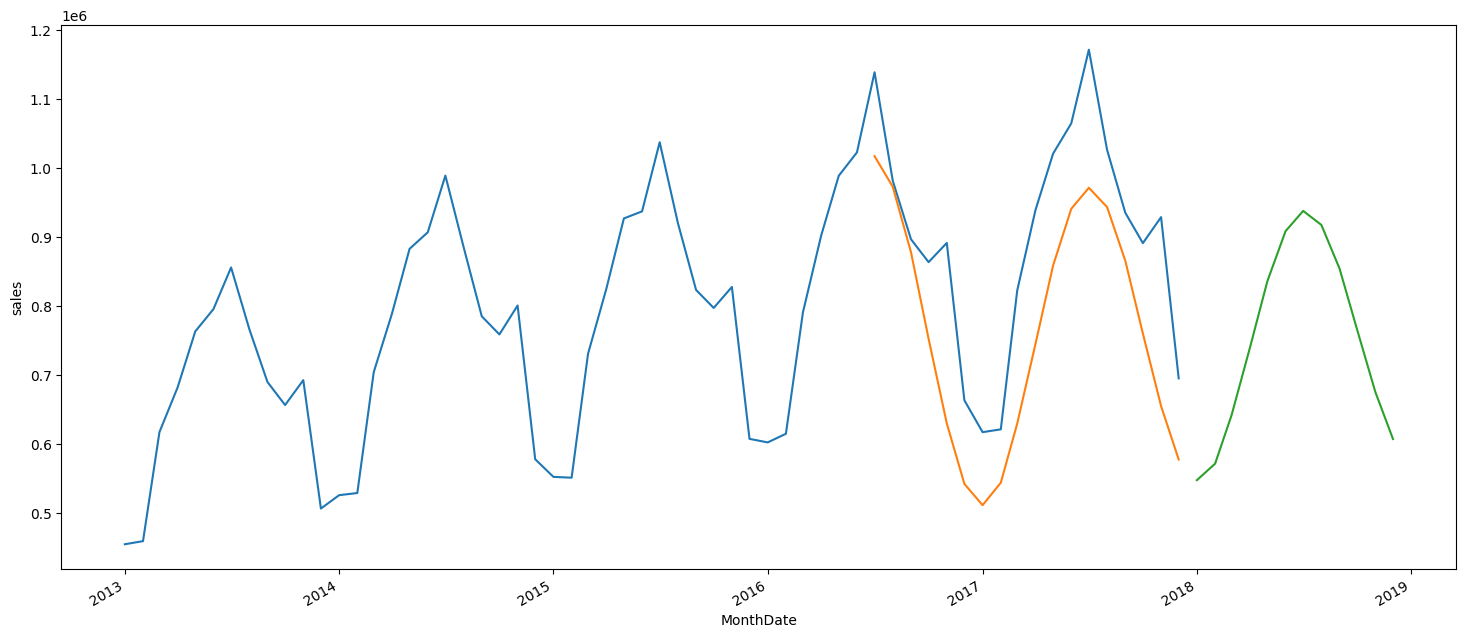

In [21]:
df_Monthly.dropna()
sns.lineplot(data=df_Monthly , x=df_Monthly.index , y='sales')
sns.lineplot(data=df_Monthly , x=df_Monthly.index , y='arimaPred')
modelAR.predict(start=dates.index[0], end=dates.index[-1]).plot()

In [22]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE
mape = mean_absolute_percentage_error(test['sales'],pred) * 100

print('MAPE:', mape, '%')

MAPE: 14.940411890487749 %


 ARIMA not performing well! an MAPE of 14% is very high which mean bad fit , lets try SARIMAX

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(train['sales'],order=(2,0,3), seasonal_order=(2,1,2,12))
modelFit=model.fit()
predi=modelFit.predict(start=test.index[0],end=test.index[-1])
df_Monthly['sarimaxPred']=predi

C:\Users\samar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\samar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\samar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Use

<Axes: xlabel='MonthDate', ylabel='sales'>

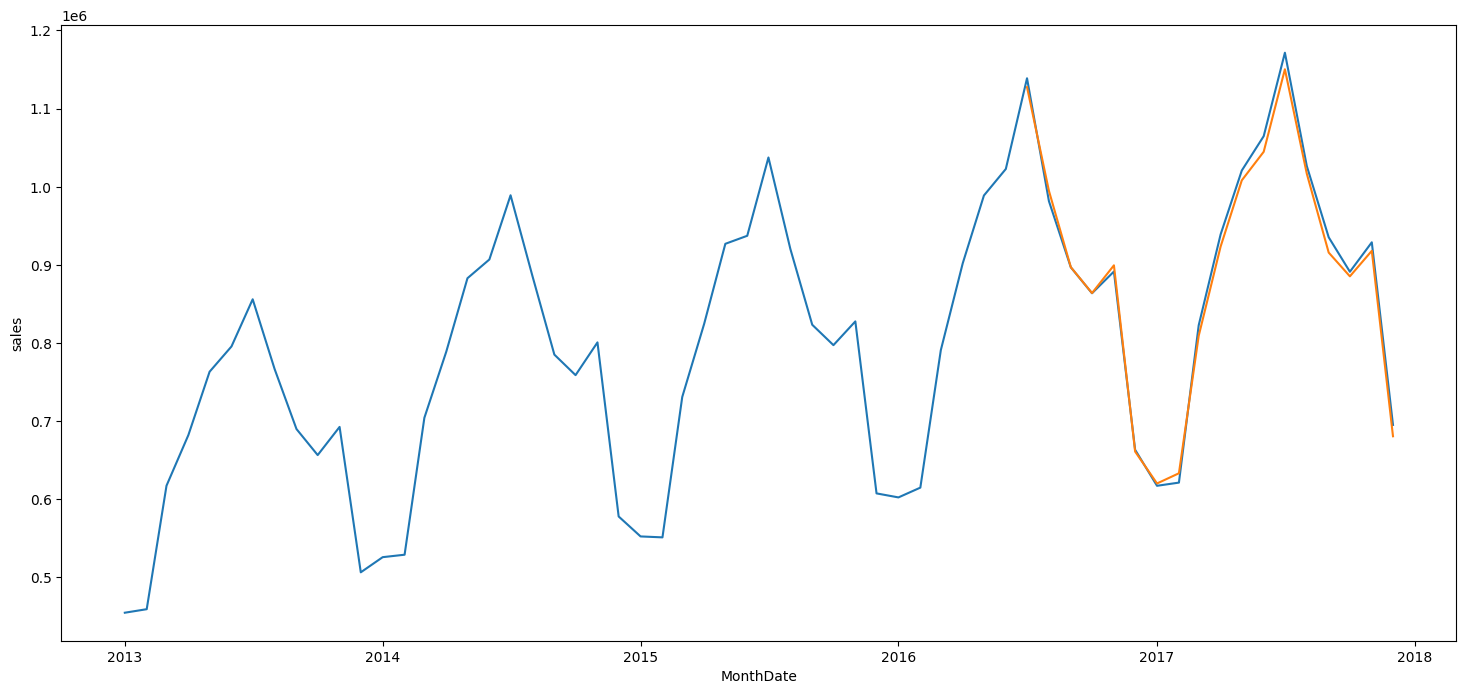

In [24]:
df_Monthly.dropna()
sns.lineplot(data=df_Monthly , x=df_Monthly.index , y='sales')
sns.lineplot(data=df_Monthly , x=df_Monthly.index , y='sarimaxPred')

Text(0.5, 0, 'Date')

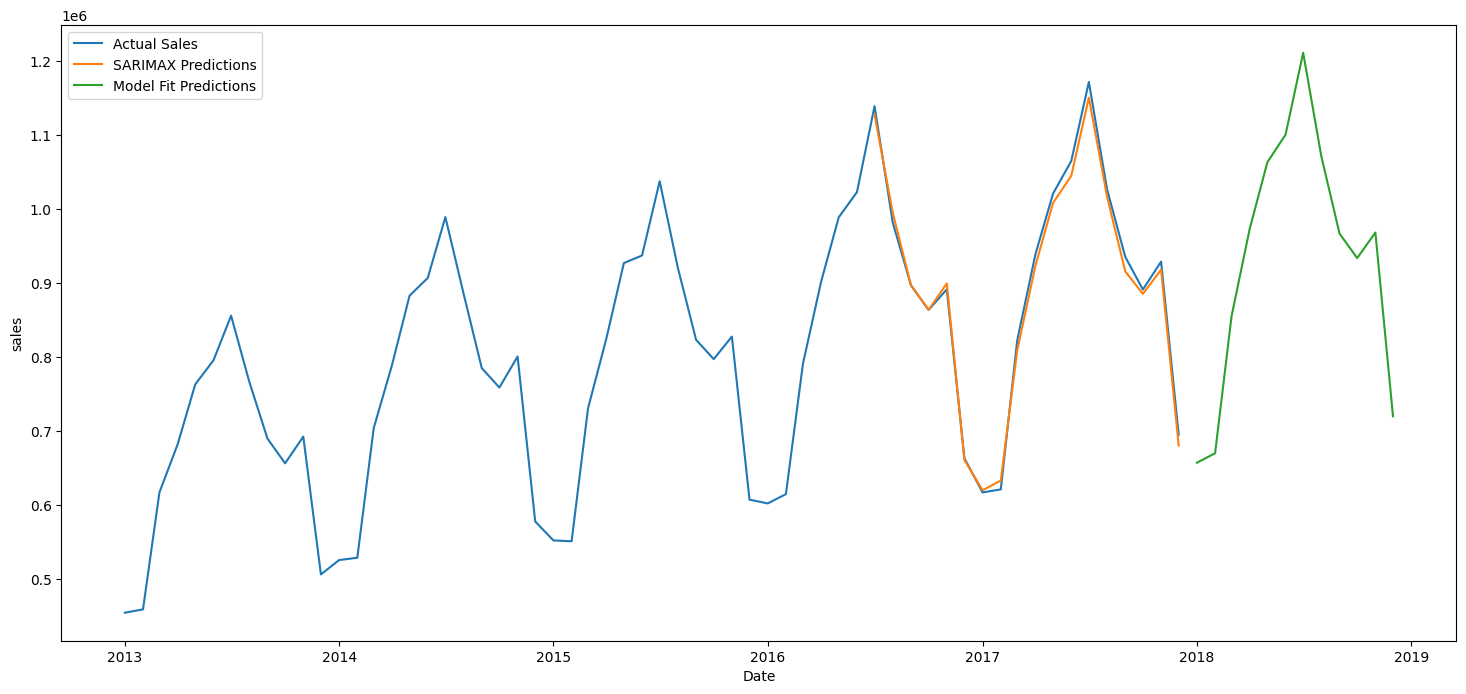

In [25]:
import matplotlib.pyplot as plt
sns.lineplot(data=df_Monthly , x=df_Monthly.index , y='sales',label='Actual Sales')
sns.lineplot(data=df_Monthly , x=df_Monthly.index , y='sarimaxPred',label='SARIMAX Predictions')
model_fit_predictions = modelFit.predict(start=dates.index[0], end=dates.index[-1])
sns.lineplot(model_fit_predictions, label='Model Fit Predictions')
plt.xlabel("Date")

In [26]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE
mape = mean_absolute_percentage_error(test['sales'],predi) * 100

print('MAPE:', mape, '%')



MAPE: 1.1777583431204213 %


A MAPE close to 0% suggests that the model is making very accurate predictions.


The Model fits well now !

In [29]:

import pandas as pd
from datetime import datetime


def predict_sales(input_date):

  
  input_date = datetime.strptime(input_date, '%Y-%m-%d')

  
  new_data = pd.DataFrame({'date': [input_date]})
  

  predicted_sales = modelFit.predict(new_data['date'].iloc[0])

  return predicted_sales[0]


user_input = input("Enter the date (2018-MM-01): ")

predicted_sales = predict_sales(user_input)

print("Predicted sales for", user_input, "is:", predicted_sales)


Predicted sales for 2018-03-01 is: 854987.4344615598
